## Purpose: create a training set of sources with labels



In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from wisps import datasets

In [3]:
#candidates
candidates=datasets['candidates'].rename(columns={'grism_id':'name'})
#reformating 
candidates[wisps.INDEX_NAMES]=candidates[wisps.INDEX_NAMES]
#candidates=wisps.Annotator.reformat_table(candidates)
#spex
spex=(datasets['spex'].rename(columns={'l_snr': 'snr1', 'l_t_snr':'snr2', 'f_x':'f_test'}))
#trash
trash=pd.read_pickle(wisps.OUTPUT_FILES+'/trash.pkl')
trash=(trash[~trash.grism_id.isin(candidates.name.values)]).rename(columns={'grism_id':'name'
})
trash['label']=0.

In [4]:
man=(datasets['manjavacas']).rename(columns={'f':'f_test'})
schn=(datasets['schneider']).rename(columns={'f':'f_test'})

In [5]:
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl')

In [6]:
simulated_spectra=sf.data.rename(columns={'f':'f_test', 'Names':'name'})
simulated_spectra=simulated_spectra[simulated_spectra.snr1>30.].sample(n=1000)

In [7]:
#len(simulated_spectra[simulated_spectra.snr1>30.])

In [8]:
candidates['spt']=candidates.spt.apply(splat.typeToNum)
spex['spt']=spex.spt.apply(splat.typeToNum)
man['spt']=man.spt.apply(splat.typeToNum)
schn['spt']=schn.spt.apply(splat.typeToNum)
trash['spt']=trash.spt.apply(splat.typeToNum)

In [9]:
#candidates=candidates[candidates.spt>19.]
#spex=spex[spex.spt>19.]

In [10]:
spex['name']=spex['grism_id']

In [11]:
features=['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont', 'spt', 'spex_chi', 'name', 'snr2','snr1', 'line_chi', 'f_test', 'f_test_cdf', 'label']

In [12]:
from scipy import stats

In [13]:
def f_test_comp(x):
    return stats.f.cdf(x, 2, 1, 0, scale=1)

man['x']=man.spex_chi/man.line_chi
schn['x']=schn.spex_chi/schn.line_chi
simulated_spectra['x']=simulated_spectra.spex_chi/simulated_spectra.line_chi
man['f_test_cdf']=man.x.apply(f_test_comp)
schn['f_test_cdf']=schn.x.apply(f_test_comp)
simulated_spectra['f_test_cdf']=simulated_spectra.x.apply(f_test_comp)
spex['f_test_cdf']=(spex.spex_chi/spex.line_chi).apply(f_test_comp)

In [14]:
def add_labels(spt):
    label=0.0
    if spt>19.:
        label=1.0
    return label

In [15]:
candidates['label']=candidates.spt.apply(add_labels)
spex['label']=spex.spt.apply(add_labels)
man['label']=man.spt.apply(add_labels)
schn['label']=schn.spt.apply(add_labels)
simulated_spectra['label']=simulated_spectra.spt.apply(add_labels)

In [16]:
##

In [17]:
training_set=pd.concat( [trash[features], candidates[features], spex[features], man[features], schn[features], simulated_spectra[features]])

In [18]:
def add_uncertainties(tupl):
    return tupl[1]

In [19]:
train_unc=training_set[wisps.INDEX_NAMES].applymap(add_uncertainties)

In [20]:
unc_columns=[x+'er' for x in wisps.INDEX_NAMES]

In [21]:
train_unc.columns=unc_columns

In [22]:
training_set_final=wisps.Annotator.reformat_table(train_unc.reset_index(drop=True).join(training_set.reset_index(drop=True),how='outer'))

In [23]:
false_things=training_set_final[training_set_final['label']==0.]

In [24]:
#choose only 10% of the true brown dwarf to reflect the ratio of true bds in the set
true_things=training_set_final[training_set_final['label']>0.]#.sample(n=int(len(false_things)/1.))

In [25]:
final_training_set=pd.concat([true_things, false_things]).reset_index(drop=True)

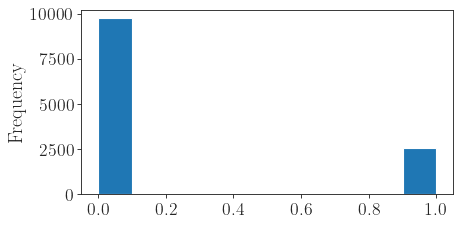

In [26]:
final_training_set.label.plot(kind='hist')

In [27]:
feats=np.append(features, unc_columns)

In [28]:
featsg=feats[feats !='name']

In [29]:
final_training_set[featsg]=final_training_set[featsg].applymap(float)
final_training_set=final_training_set.replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)
final_training_set.to_pickle(wisps.LIBRARIES+'/training_set.pkl')

In [30]:
len(trash), len(candidates[features]), len(spex[features]), len(man[features]), len(schn[features]), len(simulated_spectra[features])

(8283, 225, 2698, 77, 22, 1000)

In [31]:
len(final_training_set)

12305